In [101]:
import numpy as np
import matplotlib.pyplot as plt
import datasets
import torch
from train import get_model_class
from style import plot_grads, plot_single_grad
from similarity_metrics import get_top_k, average_pairwise_score, top_k_sa, top_k_cdc, top_k_consistency
from util import weight_distance
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
random_sources = ['rs', 'loo']

In [103]:
name = 'heloc'  # or 'german'
n_models = 1000  # 1000 for german if needed
trainset, testset = datasets.load_dataset(name)

X_test, y_test = testset.data.numpy(), testset.labels.numpy()
n_inputs, input_size = X_test.shape
model_args = [input_size, datasets.tabular.layers[name]]
directory = f'models/{name}'
directory

'models/heloc'

In [119]:
random_source = random_sources[0]

In [105]:
model_class = get_model_class(name)
model = model_class(*model_args)
state_dict = torch.load(f'{directory}/{random_source}_model_{0}.pth')
model.load_state_dict(state_dict)
# Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
grads = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)

In [106]:
first_layer = state_dict['network.0.weight'].numpy()

### Magnitudes of weight initializations

In [107]:
layers = datasets.tabular.layers[name]
input_size = trainset.data.shape[1]
layers, input_size

([128, 64, 16], 23)

100%|██████████| 1000/1000 [00:00<00:00, 2202.18it/s]


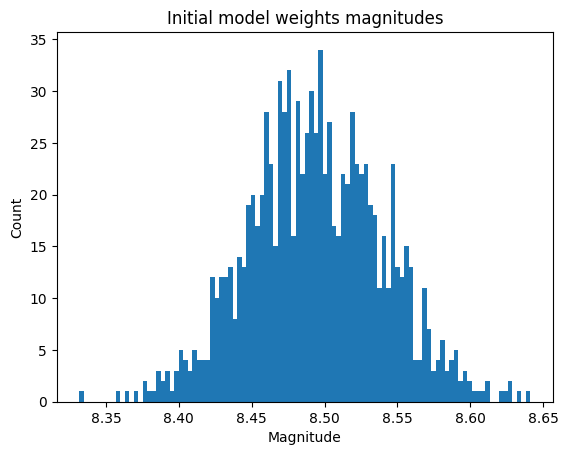

In [120]:
model_mags_init = np.zeros(n_models)
for i in tqdm(range(n_models)):
    # Initialize model with seed i
    seed = i if random_source == 'rs' else 0
    torch.manual_seed(seed)
    init_model = model_class(input_size, layers)
    state_dict = init_model.state_dict()
    for k, v in state_dict.items():
        model_mags_init[i] += torch.norm(v, p=2)**2
model_mags_init = np.sqrt(model_mags_init)
plt.hist(model_mags_init, bins=100)
plt.title('Initial model weights magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.show()

In [ ]:
pairwise_dists_init = []
for i in tqdm(range(n_models)):
    # Initialize model with seed i
    seed = i if random_source == 'rs' else 0
    torch.manual_seed(seed)
    state_dict1 = model_class(input_size, layers).state_dict()
    for j in range(i+1, n_models):
        seed = j if random_source == 'rs' else 0
        torch.manual_seed(seed)
        state_dict2 = model_class(input_size, layers).state_dict()
        pairwise_dists_init.append(weight_distance(state_dict1, state_dict2))
pairwise_dists_init = np.array(pairwise_dists_init)

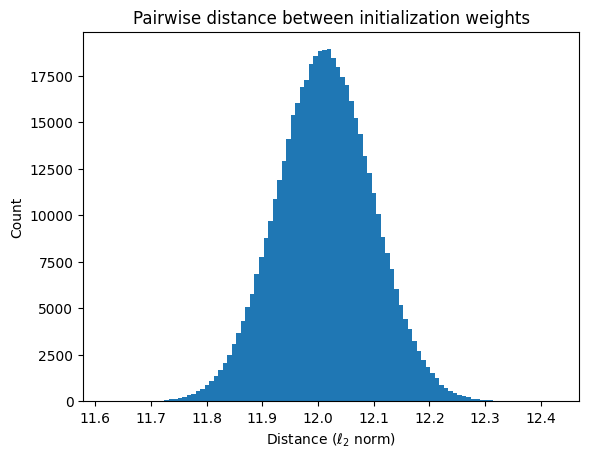

Min pairwise distance: 11.618672
Mean pairwisedistance: 12.012472
Max pairwise distance: 12.428462


In [125]:
plt.hist(pairwise_dists_init, bins=100)
plt.title('Pairwise distance between initialization weights')
plt.xlabel('Distance ($\ell_2$ norm)')
plt.ylabel('Count')
plt.show()
print("Min pairwise distance:", pairwise_dists_init.min())
print("Mean pairwisedistance:", pairwise_dists_init.mean())
print("Max pairwise distance:", pairwise_dists_init.max())

### Magnitudes of trained model weights

100%|██████████| 1000/1000 [00:00<00:00, 1666.82it/s]


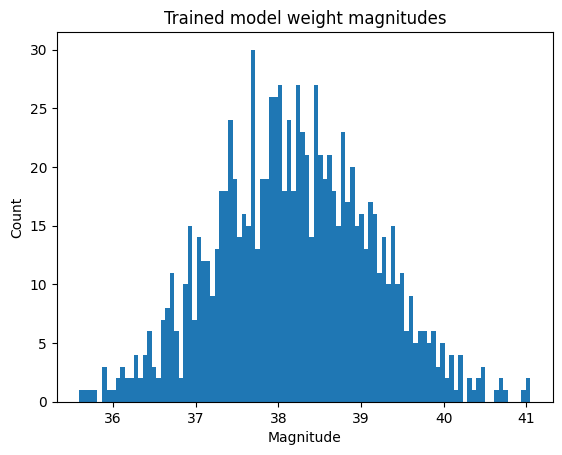

In [113]:
model_mags = np.zeros(n_models)
# Compute magnitude of all weights in each model
for i in tqdm(range(n_models)):
    state_dict = torch.load(f'{directory}/{random_source}_model_{i}.pth')
    for k, v in state_dict.items():
        model_mags[i] += torch.norm(v, p=2)**2
model_mags = np.sqrt(model_mags)
plt.hist(model_mags, bins=100)
plt.title('Trained model weight magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.show()

### Distance between trained models

In [ ]:
pairwise_dists = []
for i in tqdm(range(n_models)):
    state_dict1 = torch.load(f'{directory}/{random_source}_model_{i}.pth')
    for j in range(i+1, n_models):
        state_dict2 = torch.load(f'{directory}/{random_source}_model_{j}.pth')
        pairwise_dists.append(weight_distance(state_dict1, state_dict2))
pairwise_dists = np.array(pairwise_dists)

100%|██████████| 1000/1000 [01:52<00:00,  8.88it/s]


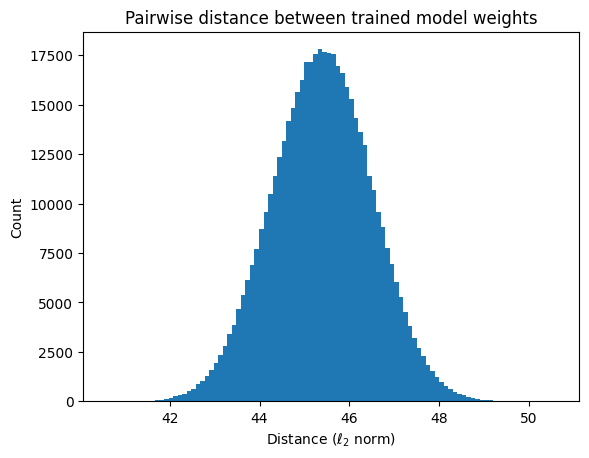

Min pairwise distance: 40.569763
Mean pairwisedistance: 45.3952
Max pairwise distance: 50.62323
If models are orthogonal in weight space, the rough mean distance between them should be:
Mean model weight magnitude multiplied by sqrt(2) =  54.016939245437
For reference, the minimum pairwise distance (0) would occur if two models had the same weights,
and the maximum pairwise distance (2 times max model norm) would occur if two models had opposite weights,
which would be around model_mags.max()*2 =  82.09345558093379
So it appears that models are roughly orthogonal in weight space.


In [ ]:
# Random source is loo
plt.hist(pairwise_dists, bins=100)
plt.title('Pairwise distance between trained model weights')
plt.xlabel('Distance ($\ell_2$ norm)')
plt.ylabel('Count')
plt.show()
print("Min pairwise distance:", pairwise_dists.min())
print("Mean pairwisedistance:", pairwise_dists.mean())
print("Max pairwise distance:", pairwise_dists.max())
print("If models are orthogonal in weight space, the rough mean distance between them should be:")
print("Mean model weight magnitude multiplied by sqrt(2) = ", model_mags.mean()*np.sqrt(2))
print("For reference, the minimum pairwise distance (0) would occur if two models had the same weights,")
print("and the maximum pairwise distance (2 times max model norm) would occur if two models had opposite weights,")
print("which would be around model_mags.max()*2 = ", model_mags.max()*2)
print("So it appears that models are roughly orthogonal in weight space.")

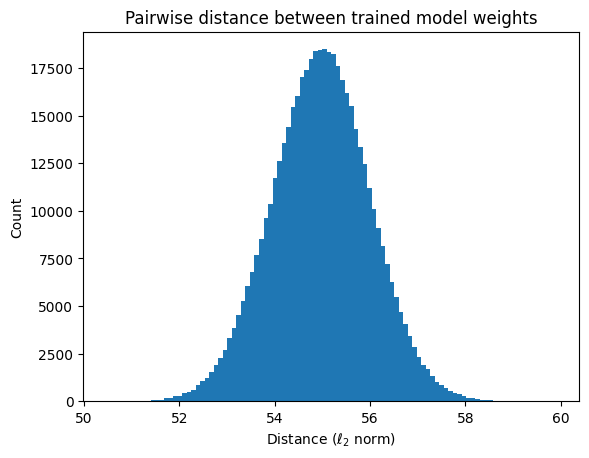

Min pairwise distance: 50.457794
Mean pairwisedistance: 54.970196
Max pairwise distance: 59.91243
If models are orthogonal in weight space, the rough mean distance between them should be:
Mean model weight magnitude multiplied by sqrt(2) =  57.00979950169064
For reference, the minimum pairwise distance (0) would occur if two models had the same weights,
and the maximum pairwise distance (2 times max model norm) would occur if two models had opposite weights,
which would be around model_mags.max()*2 =  87.33460092959291
So it appears that models are roughly orthogonal in weight space.


In [ ]:
# Random source is rs
plt.hist(pairwise_dists, bins=100)
plt.title('Pairwise distance between trained model weights')
plt.xlabel('Distance ($\ell_2$ norm)')
plt.ylabel('Count')
plt.show()
print("Min pairwise distance:", pairwise_dists.min())
print("Mean pairwisedistance:", pairwise_dists.mean())
print("Max pairwise distance:", pairwise_dists.max())
print("If models are orthogonal in weight space, the rough mean distance between them should be:")
print("Mean model weight magnitude multiplied by sqrt(2) = ", model_mags.mean()*np.sqrt(2))
print("For reference, the minimum pairwise distance (0) would occur if two models had the same weights,")
print("and the maximum pairwise distance (2 times max model norm) would occur if two models had opposite weights,")
print("which would be around model_mags.max()*2 = ", model_mags.max()*2)
print("So it appears that models are roughly orthogonal in weight space.")

### Distance between initializations and trained models

100%|██████████| 1000/1000 [00:01<00:00, 907.54it/s]


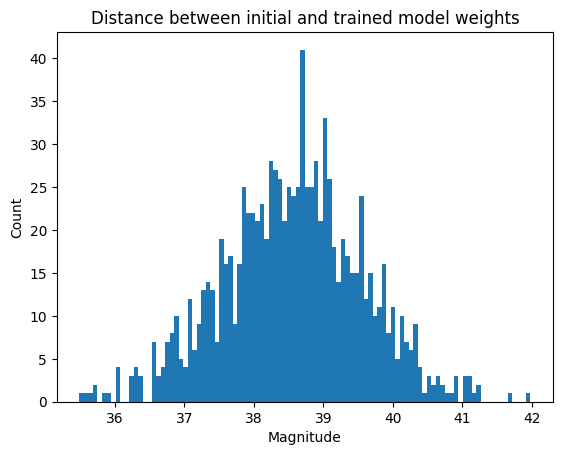

In [130]:
model_mags_init_train = np.zeros(n_models)
for i in tqdm(range(n_models)):
    # Initialize model with seed i
    seed = i if random_source == 'rs' else 0
    torch.manual_seed(seed)
    init_model = model_class(input_size, layers)
    state_dict_init = init_model.state_dict()


    state_dict_trained = torch.load(f'{directory}/{random_source}_model_{i}.pth')
    for k, v in state_dict_init.items():
        model_mags_init_train[i] += torch.norm(v-state_dict_trained[k], p=2)**2

model_mags_init_train = np.sqrt(model_mags_init_train)
plt.hist(model_mags_init_train, bins=100)
plt.title('Distance between initial and trained model weights')
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.show()

### Magnitude of noise added to weights

In [46]:
np.logspace(-2, -0.3, 20)

array([0.01      , 0.01228779, 0.01509897, 0.0185533 , 0.02279789,
       0.02801357, 0.03442248, 0.04229761, 0.0519744 , 0.06386504,
       0.078476  , 0.09642964, 0.11849069, 0.14559883, 0.17890875,
       0.21983926, 0.27013381, 0.33193468, 0.40787428, 0.50118723])

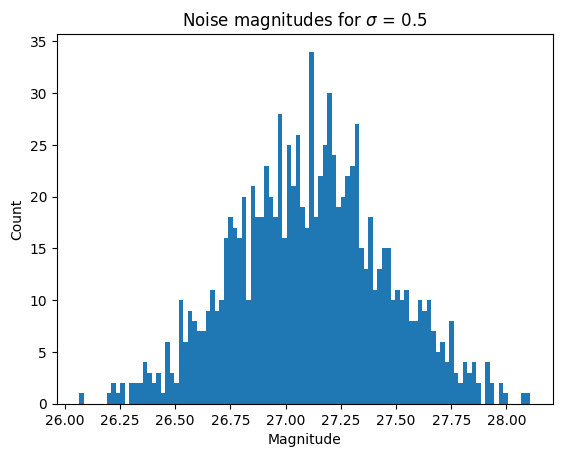

In [131]:
n_samples = 1000
layer_str = 'network.0.weight'
sigma = 0.5
noise_mags = np.zeros(n_samples)
for i in range(n_samples):
    noise = torch.randn(state_dict[layer_str].shape) * sigma
    noise_mags[i] = np.linalg.norm(noise.numpy())
plt.hist(noise_mags, bins=100)
plt.title('Noise magnitudes for $\sigma$ = 0.5')
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.show()

100%|██████████| 20/20 [00:01<00:00, 19.98it/s]


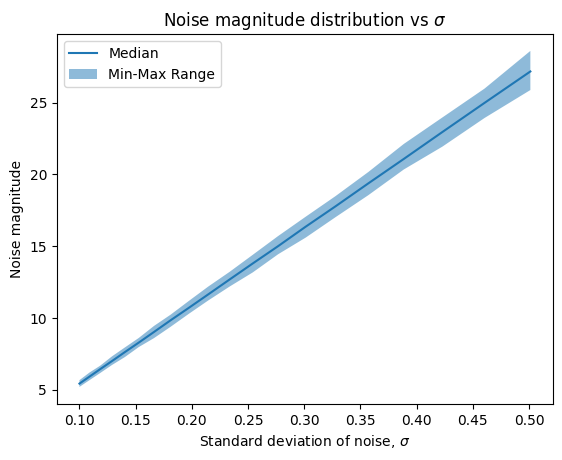

In [58]:
n_samples = 1000
layer_str = 'network.0.weight'
sigmas = np.logspace(-1, -0.3, 20)
noise_mags = np.zeros((len(sigmas), n_samples))
for i, sigma in enumerate(tqdm(sigmas)):
    for j in range(n_samples):
        #noise = np.random.normal(0, sigma**2, state_dict[layer_str].numpy().shape)
        noise = torch.randn(state_dict[layer_str].shape) * sigma
        noise_mags[i, j] = np.linalg.norm(noise.numpy())
q = np.quantile(noise_mags, [0, 0.5, 1], axis=1)
plt.title('Noise magnitude distribution vs $\sigma$')
plt.plot(sigmas, q[1], label='Median')
plt.fill_between(sigmas, q[0], q[2], alpha=0.5, label='Min-Max Range')
#plt.xscale('log')
plt.xlabel('Standard deviation of noise, $\sigma$')
plt.ylabel('Noise magnitude')
plt.legend()
plt.show()

### Magnitudes of noisy model weights

In [115]:
sigma = 0.5
n_samples = 100
layer_str = 'network.0.weight'
noisy_model_mags = np.zeros((n_models, n_samples))
for i in tqdm(range(n_models)):
    state_dict = torch.load(f'{directory}/{random_source}_model_{i}.pth')
    fixed_mag = 0
    for k, v in state_dict.items():
        if k != layer_str:
            fixed_mag += torch.norm(v, p=2)**2
    for j in range(n_samples):
        noisy_layer = state_dict[layer_str] + torch.randn(state_dict[layer_str].shape) * sigma
        noisy_layer_mag = torch.norm(noisy_layer, p=2)**2
        noisy_model_mags[i, j] = np.sqrt(noisy_layer_mag + fixed_mag)
        

100%|██████████| 1000/1000 [00:06<00:00, 149.28it/s]


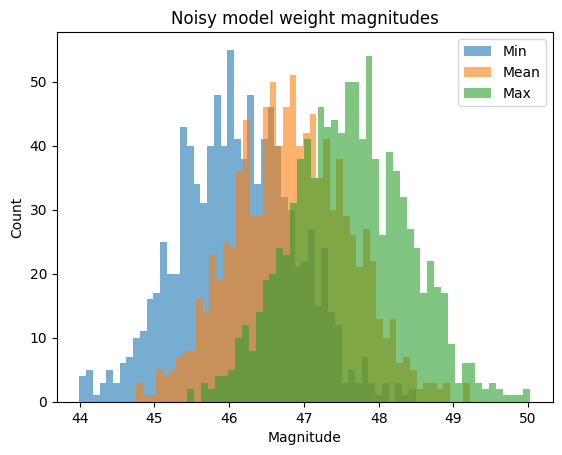

Each 'count' represents a model. The min, mean, and max of the noisy model weights are shown.


In [116]:
bins, alpha = 50, 0.6
plt.hist(noisy_model_mags.min(axis=1), bins=bins, label='Min', alpha=alpha)
plt.hist(noisy_model_mags.mean(axis=1), bins=bins, label='Mean', alpha=alpha)
plt.hist(noisy_model_mags.max(axis=1), bins=bins, label='Max', alpha=alpha)
plt.legend()
plt.title('Noisy model weight magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.show()
print("Each 'count' represents a model. The min, mean, and max of the noisy model weights are shown.")

### Distance between trained models with noise added

In [99]:
pairwise_dists_noise = []
for i in tqdm(range(n_models)):
    state_dict1 = torch.load(f'{directory}/{random_source}_model_{i}.pth')
    # Add noise to the first model
    noise = torch.randn(state_dict[layer_str].shape) * sigma
    state_dict1[layer_str] += noise
    for j in range(i+1, n_models)a:
        state_dict2 = torch.load(f'{directory}/{random_source}_model_{j}.pth')
        # Add noise to the second model
        noise = torch.randn(state_dict[layer_str].shape) * sigma
        state_dict2[layer_str] += noise

        # Compute distance between noisy models
        pairwise_dists_noise.append(weight_distance(state_dict1, state_dict2))
pairwise_dists_noise = np.array(pairwise_dists_noise)

100%|██████████| 1000/1000 [02:17<00:00,  7.29it/s]


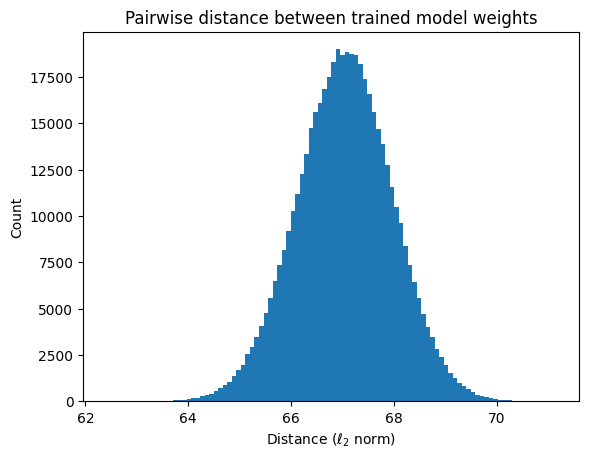

Min pairwise distance: 62.39498
Mean pairwisedistance: 67.04563
Max pairwise distance: 71.16934


In [100]:
plt.hist(pairwise_dists_noise, bins=100)
plt.title('Pairwise distance between trained model weights')
plt.xlabel('Distance ($\ell_2$ norm)')
plt.ylabel('Count')
plt.show()
print("Min pairwise distance:", pairwise_dists_noise.min())
print("Mean pairwisedistance:", pairwise_dists_noise.mean())
print("Max pairwise distance:", pairwise_dists_noise.max())

### One model, Gaussian noise (mean = 0, std. dev = sigma) on first layer

In [29]:
sigma = 0.5
model_idx = 0
model_class = get_model_class(name)
model = model_class(*model_args)
state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx}.pth')
model.load_state_dict(state_dict)
# Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
original_grads = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
original_preds = model.predict(X_test, return_numpy=True)

In [30]:
n_samples = 1000
noisy_grads = np.zeros((n_samples, *original_grads.shape))
noisy_preds = np.zeros((n_samples, original_preds.shape[0]))
for i in tqdm(range(n_samples)):
    model = model_class(*model_args)
    state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx}.pth')
    # Add noise to layer weights
    layer_str = 'network.0.weight'
    layer = state_dict[layer_str].numpy()
    layer += np.random.normal(0, sigma**2, layer.shape)
    state_dict[layer_str] = torch.from_numpy(layer)
    model.load_state_dict(state_dict)
    # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
    noisy_grads[i] = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
    noisy_preds[i] = model.predict(X_test, return_numpy=True)

100%|██████████| 1000/1000 [00:03<00:00, 303.36it/s]


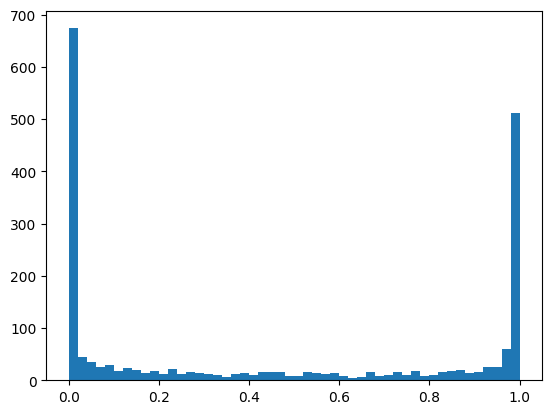

In [97]:
plt.hist(noisy_preds.mean(axis=0), bins=50)
plt.show()

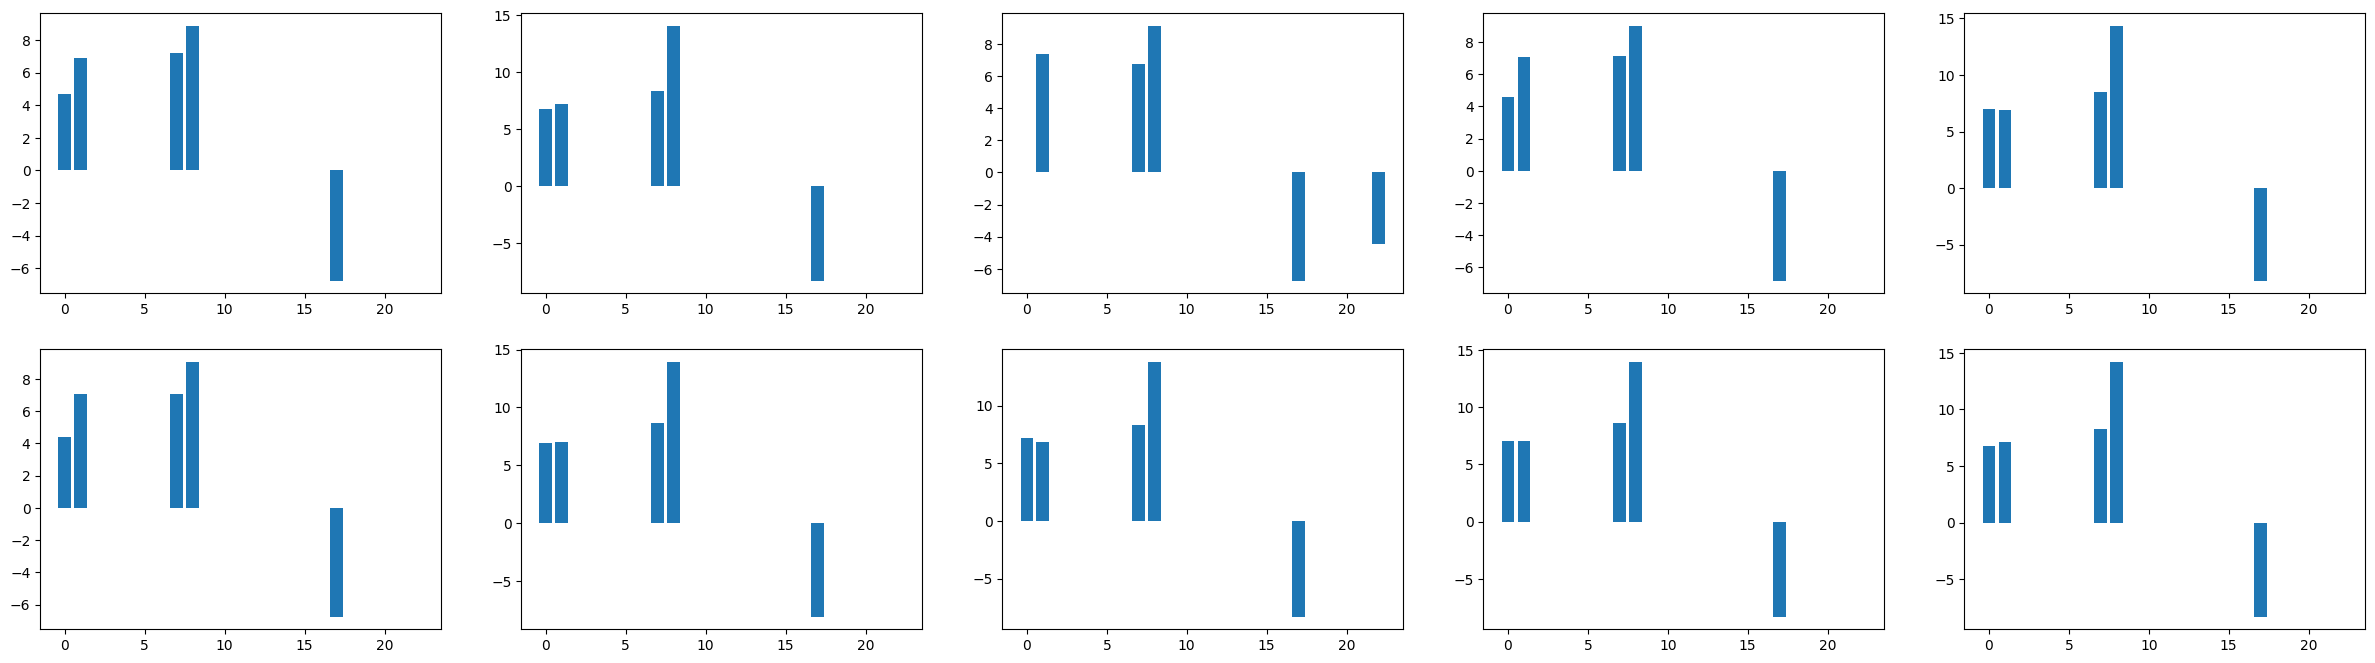

In [59]:
plot_grads(noisy_grads[:10, 2], nrows=2, ncols=5, k=5)

### Multiple Models

In [354]:
ensemble_size = 100
sigma = 0.5
n_samples = 100
model_class = get_model_class(name)
model_idx = np.random.choice(n_models, ensemble_size, replace=False)
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in model_idx])
preds = np.array([np.load(f'{directory}/{random_source}_preds_{idx}.npy') for idx in model_idx])
model_idx

array([571, 470, 251, 365, 825, 821, 334, 630, 600, 282, 330, 156, 664,
       880, 631, 548, 897, 408, 419, 863, 508, 778, 215, 462, 956,  61,
        80, 877, 140, 164, 388, 110, 246, 917, 467, 632, 410, 869, 243,
       339, 518, 207, 184, 649, 231, 650, 112, 383,  78, 310, 737, 180,
       643, 132, 748, 793, 624,  40, 829, 125, 867, 526, 644, 808, 338,
       494, 281, 732, 183, 451, 741, 823,  91, 794, 380, 777, 752, 130,
       903, 402, 325, 363, 496, 995, 520, 381, 730, 509, 767, 151, 517,
       277, 769, 340,  68,  13, 212, 994, 368, 942])

In [355]:
noisy_grads = np.zeros((n_samples, *grads.shape))
noisy_preds = np.zeros((n_samples, *preds.shape))
layer_str = 'network.0.weight'
for j in tqdm(range(len(model_idx))):
    for i in range(n_samples):
        model = model_class(*model_args)
        state_dict = torch.load(f'{directory}/{random_source}_model_{model_idx[j]}.pth')
        # Add noise to layer weights
        state_dict[layer_str] += torch.randn(state_dict[layer_str].shape) * sigma
        model.load_state_dict(state_dict)

        # Compute positive class softmax prediction gradient wrt input (softmax=False for logit output)
        noisy_grads[i, j] = model.compute_gradients(X_test, softmax=False, label=1, return_numpy=True)
        noisy_preds[i, j] = model.predict(X_test, return_numpy=True)

100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


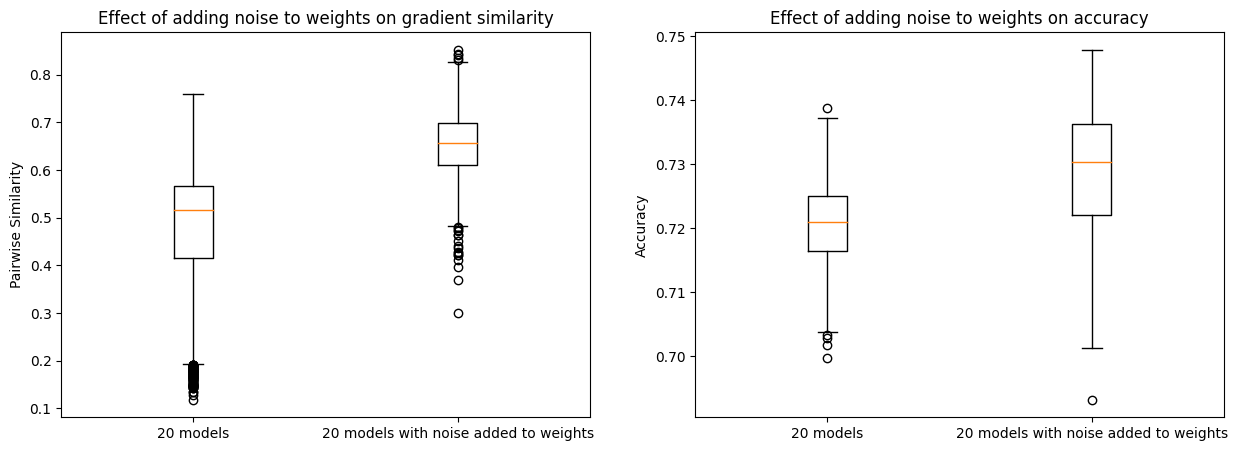

In [356]:
tk, s = get_top_k(5, grads, return_sign=True)
sa = average_pairwise_score(tk, s, top_k_sa)
tk_smooth, s_smooth = get_top_k(5, noisy_grads.mean(axis=0), return_sign=True)
sa_smooth = average_pairwise_score(tk_smooth, s_smooth, top_k_sa)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].boxplot([sa, sa_smooth], labels=['20 models', '20 models with noise added to weights'])
ax[0].set_title('Effect of adding noise to weights on gradient similarity')
ax[0].set_ylabel('Pairwise Similarity')

smooth_preds = np.where(noisy_preds.mean(axis=0) > 0.5, 1, 0)
smooth_acc = (smooth_preds==y_test).mean(axis=1)
orig_acc = (preds==y_test).mean(axis=1)
ax[1].boxplot([orig_acc, smooth_acc], labels=['20 models', '20 models with noise added to weights'])
ax[1].set_title('Effect of adding noise to weights on accuracy')
ax[1].set_ylabel('Accuracy')

plt.show()

In [353]:
ensemble_preds = np.where(preds.mean(axis=0) > 0.5, 1, 0)
smooth_ensemble_preds = np.where(smooth_preds.mean(axis=0) > 0.5, 1, 0)
(ensemble_preds==y_test).mean(), (smooth_ensemble_preds==y_test).mean()

(0.7296202531645569, 0.7326582278481013)

### Comparison to 1000 average

In [360]:
grads = np.array([np.load(f'{directory}/{random_source}_grads_{idx}.npy') for idx in range(1000)])

In [390]:
tk_all, s_all = get_top_k(5, grads, return_sign=True)
tk_all.shape

(1000, 1975, 5)

In [381]:
vote = np.zeros(grads.shape[1:])
vote.shape

(1975, 23)

In [391]:
for i in range(tk_all.shape[0]):
    for j in range(tk_all.shape[1]):
        vote[j, tk_all[i, j]] += s_all[i, j]

In [394]:
tk_vote, s_vote = get_top_k(5, vote, return_sign=True)
tk_vote*s_vote

array([[  0,   3,  14,   4, -17],
       [  7,   3, -21,  14,   0],
       [  7,  14,   0,   3,   8],
       ...,
       [  0,  14,   7,   3, -21],
       [ 14,   4,   3,   7, -19],
       [  3,   0,   1,  14, -17]])

In [397]:
grads.mean(axis=0).shape

(1975, 23)

In [402]:
tk_mean_all, s_mean_all = get_top_k(5, grads.mean(axis=0), return_sign=True)
tk_mean_all*s_mean_all

array([[  4,   3,  14,   0,  10],
       [  7, -21, -17,  14,   3],
       [  7,   0,   8, -15,   1],
       ...,
       [  0,  14,   7, -21,   3],
       [ 14,   4,   3,   7, -19],
       [  3,   0,   1,  14, -17]])

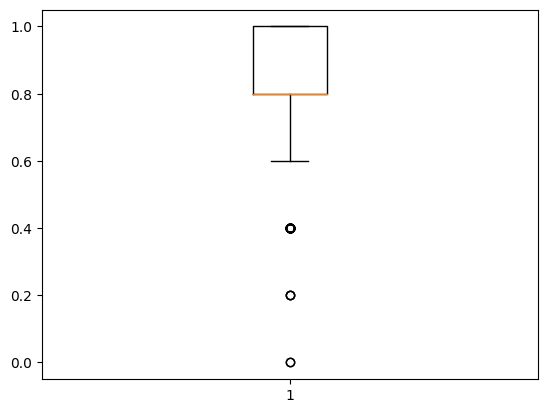

In [401]:
plt.boxplot(top_k_sa(tk_mean_all, tk_vote, s_mean_all, s_vote))
plt.show()